# Introduction

The aim of our project is to create question-answering system/application/bot/program based on deep learning that answers in style of language used in Avatar: The Legend of Aang (officially known as Avatar: The Last Airbender). Three of us, namely Ania, Konrad and Witek are familiar with the cartoon, but I, Jacek, have never watched even a single episode. However, approaches using deep learning require empirical evaluation. Thus, I perform Exploratory Data Analysis to allow our team performing evaluation by two kinds of experts - practical one, who knows the language due to many hours spent in from on a screen, on gaining expertise in the field of language used in ATLA world and theoretical one, who knows the language only based on some statistics.

I start the exploration with reading data and visualizing characters frequency. Please notice, that in this notebook I work with raw data. Function `src/data.py:read_dataframe` returns data that had been processed based on discoveries of the below notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
df = pd.read_csv('../data/avatar.csv', encoding = 'unicode_escape').drop(columns=['Unnamed: 0', 'id'])
df.head()

,book,book_num,chapter,chapter_num,character,full_text,character_words,writer,director,imdb_rating
0,Water,1,The Boy in the Iceberg,1,Katara,Water. Earth. Fire. Air. My grandmother used t...,Water. Earth. Fire. Air. My grandmother used t...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
1,Water,1,The Boy in the Iceberg,1,Scene Description,"As the title card fades, the scene opens onto ...",NaN,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
2,Water,1,The Boy in the Iceberg,1,Sokka,It's not getting away from me this time. [Clos...,It's not getting away from me this time. Watc...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
3,Water,1,The Boy in the Iceberg,1,Scene Description,"The shot pans quickly from the boy to Katara, ...",NaN,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
4,Water,1,The Boy in the Iceberg,1,Katara,"[Happily surprised.] Sokka, look!","Sokka, look!","<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1


In [3]:
speakers = df.groupby(['character']).size().sort_values(ascending=False)

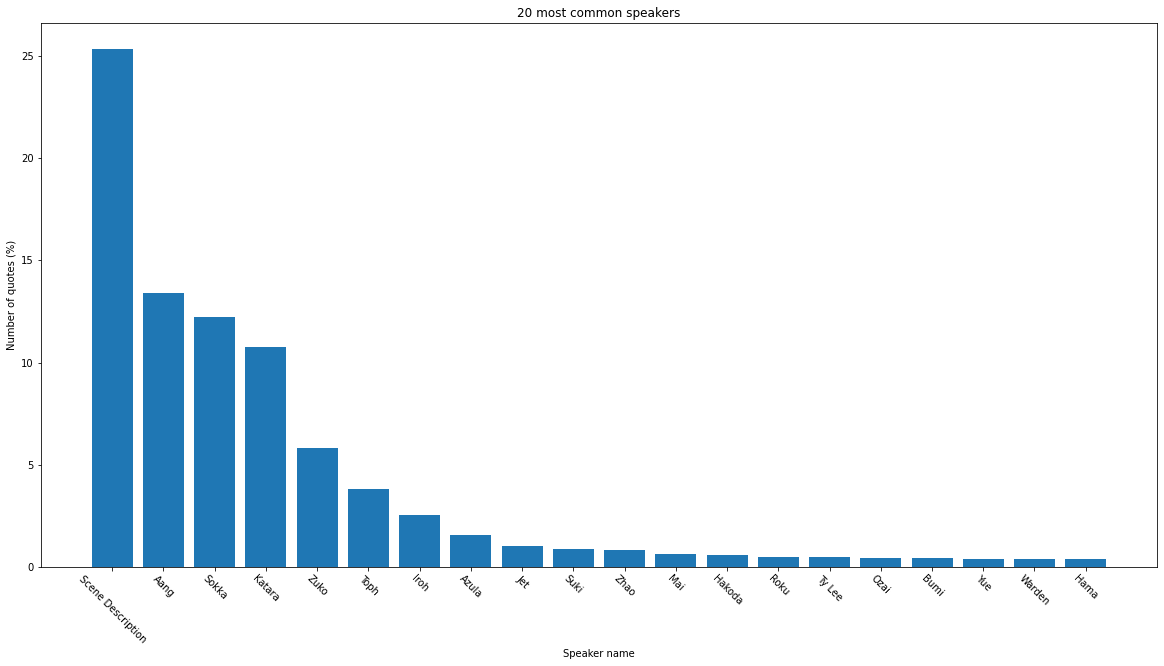

In [4]:
plt.bar(x=speakers.index[:20], height=speakers.values[:20] / speakers.values.sum() * 100)
plt.xticks(rotation=-45)
plt.title('20 most common speakers')
plt.ylabel('Number of quotes (%)')
plt.xlabel('Speaker name')
plt.show()

# Preprocessing
The plot above shows that there is character named "Scene Description". Scene descriptions are useless for the sake of text (speach) generation. I verify its participation in the whole dataset.

In [5]:
total = df.shape[0]
characters = df[df['character'] != 'Scene Description'].shape[0]
descriptions = df[df['character'] == 'Scene Description'].shape[0]
print(f"{'Total number of expressions:':<30}{total:<10}")
print(f"{'Characters statements:':<30}{characters:<6}( {characters/total * 100:.2f}% )")
print(f"{'Scene descriptions:':<30}{descriptions:<6}( {descriptions/total * 100:.2f}% )")

Total number of expressions:  13385     
Characters statements:        9992  ( 74.65% )
Scene descriptions:           3393  ( 25.35% )


There are also some troublesome characters in the file:

| occurences    | character         |
|---------------|-------------------|
| 1766          | Aang              |
| 2             | Aang and Sokka    |
| 1             | Aang and Zuko     |
| 1             | Aang:             |
| 1             | Actor Bumi        |
| 5             | Actor Iroh        |
| 2             | Actor Jet         |
| 5             | Actor Ozai        |
| 16            | Actor Sokka       |
| 3             | Actor Toph        |
| 14            | Actor Zuko        |
| 19            | Actress Aang      |
| 10            | Actress Azula     |
| 16            | Actress Katara    |

Hence, we perform some preprocessing, consecutively executing the following steps:
1. Drop scene descriptions.
2. Drop statements spoken by more than 1 character - there is no simple way to assign them to the proper character. Thus, to avoid manual labeling we drop them, because there are only few of thems.
3. Lower all character names.
4. Remove tokens like ":", "actor", "actress" from character names.
5. Transform name to upper case.

The following pipeline has been implemented in `src/data.py:read_data()`

In [6]:
df = pd.read_csv('../data/avatar.csv', encoding = 'unicode_escape').drop(columns=['Unnamed: 0', 'id'])

In [7]:
df = df[df['character'] != 'Scene Description']
df = df[~df['character'].str.contains('and')]
df['character'] = df['character'].str.lower()
df['character'] = df['character'].str.replace(':|actor|actress', '', regex=True)
df['character'] = df['character'].str.strip().str.title()
df = df.reset_index()
df = df.drop(columns=['index'])

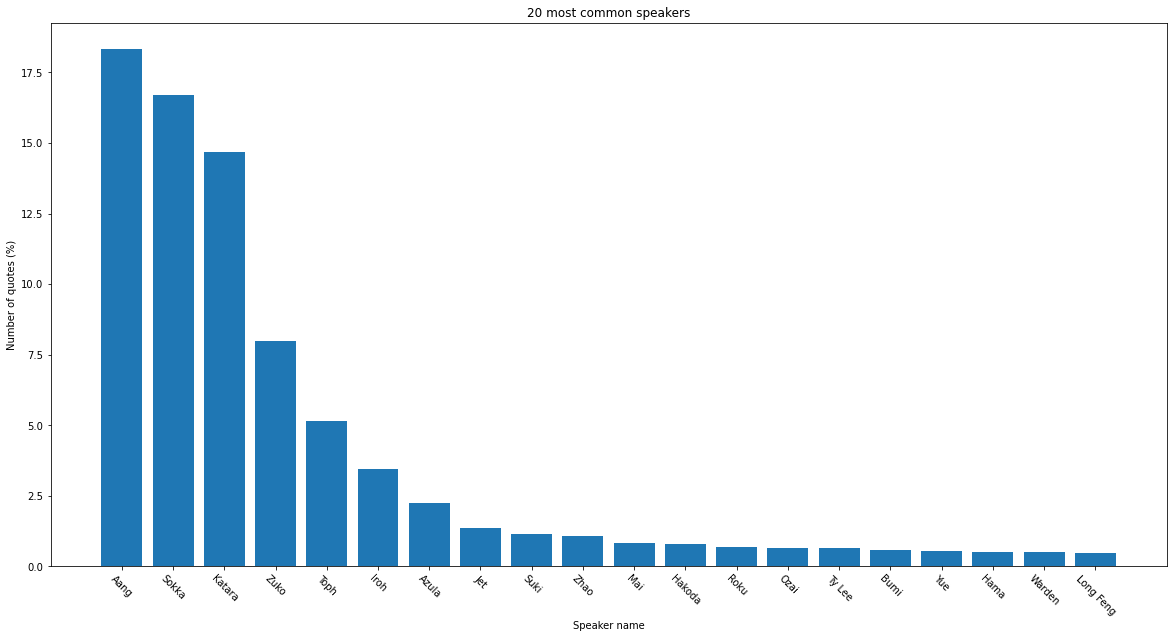

In [8]:
speakers = df.groupby(['character']).size().sort_values(ascending=False)

plt.bar(x=speakers.index[:20], height=speakers.values[:20] / speakers.values.sum() * 100)
plt.xticks(rotation=-45)
plt.title('20 most common speakers')
plt.ylabel('Number of quotes (%)')
plt.xlabel('Speaker name')
plt.show()

# Exploratory Data Analysis

## Start the party off with some fun
Before performing boring EDA let's create something fun, probably not very informative, but definitely cool. Below I create wordcloud - the bigger, the more frequent word.

In [9]:
from wordcloud import WordCloud

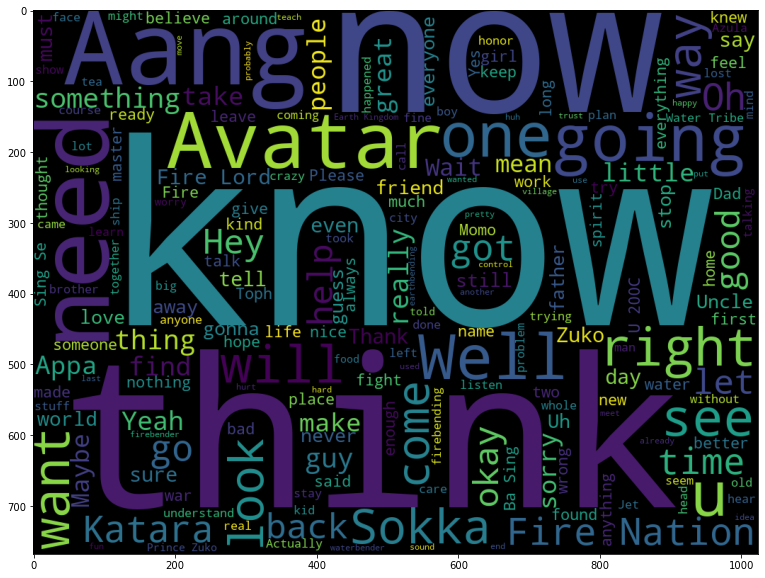

In [10]:
wc = WordCloud(width=1024, height=768).generate(" ".join(df['character_words']))
plt.imshow(wc)

When I was preparing the visualization above I thought that it will useless, and I will know nothing from the visualization. I'm surprised because actually there are some interesting words like "Avatar" that occurs quite often. I thought that this i s term used to describe something like universum. Now I know that is not true and "Avatar" is a person who is master in all four natural elements. We can also observe that along to Aang (main) important characters are Sokka and Katara. Interesting thing is that Prince Zuko (left-hand side of the image) and Fire Lord (top part of the image) occur together. The last think I want to point out is the size of word "now" - it suggests that the actin takes place in presence and there are not so much story telling or making plans.

## English in atla and ordinary world
I want to verify whether general english and ATLA english are similar. To determine this we compare most frequent words in both english types.

In [11]:
import requests
import nltk

nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jkarolczak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/jkarolczak/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jkarolczak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

lemmatize = lambda x: lemmatizer.lemmatize(x, get_wordnet_pos(nltk.pos_tag([x])[0][1]))

In [13]:
freq_atla = df['character_words'].str.lower().str.replace('[^\w\s]', '', regex=True).str.split(expand=True).stack().apply(lemmatize).value_counts().reset_index()
freq_atla[0] = (freq_atla[0] / sum(freq_atla[0]))
freq_atla = freq_atla.values[:20, 0].tolist()
freq_eng = requests.get('https://raw.githubusercontent.com/pkLazer/password_rank/master/4000-most-common-english-words-csv.csv').text.splitlines()[1:101]

In [14]:
print(f'Differences: {len(set(freq_atla).difference(freq_eng[:20]))}')
print('Popular in atla but not in common english')
print(set(freq_atla).difference(freq_eng[:20]))
print('Popular in common english but not in atla')
print(set(freq_eng[:20]).difference(freq_atla))

Differences: 13
Popular in atla but not in common english
{'be', 'i', 'in', 'we', 'it', 'a', 'me', 'of', 'your', 'do', 'my', 'to', 'im'}
Popular in common english but not in atla
{'but', 'who', 'say', 'with', 'can', 'not', 'their', 'she', 'from', 'they', 'as', 'for', 'his'}


We can observe that differences are minor. Mismatched tokens are similar parts of speach. The only difference seems to be that in atla more often singular forms of persons are used than in ordinary english (in which more plural forms are used). But proposed comparison is pretty imperfect. Some minor differences, like word from the atla subset being 21st most popular in ordinary language is counted as an error. Thus, we look for words that are in 20 most popular in atla, but don't occur in first 100 tokens of common english.

In [15]:
print(len(set(freq_atla).difference(freq_eng[:100])))
print(set(freq_atla).difference(freq_eng[:100]))

12
{'be', 'i', 'in', 'we', 'it', 'a', 'me', 'of', 'do', 'my', 'to', 'im'}


It's very surprising that so many tokens are not included in first 100 tokens in ordinary English. This confirms hypothesis that in ATLA many sentences are spoken using "I", "me" or "my".

## Characters similarities
In this step I want to find most similar characters. The similarity will be determined using pairwise cosine similarity between tf-idf representation of all statements spoken by a character merged to one.

In [16]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
join = lambda x: ' '.join(sum([val for val in x.values], []))

df_chr_str = pd.DataFrame(df['character_words'].str.lower().str.replace('[^\w\s]', '', regex=True).str.split(expand=False))
df_chr_str.insert(0, 'character', df['character'])
df_chr_str = df_chr_str.groupby('character').agg({'character_words': join})

cos_sim = cosine_similarity(TfidfVectorizer().fit_transform(df_chr_str['character_words'].tolist()))
np.fill_diagonal(cos_sim, 0)

idxs = np.unravel_index(np.argsort(cos_sim.ravel())[-10:], cos_sim.shape)
idxs = np.array(idxs).T
idxs.sort(axis=1)
idxs = np.unique(idxs, axis=0)

In [18]:
for i, (x, y) in enumerate(idxs):
    print(f'{df_chr_str.index[x]} and {df_chr_str.index[y]}')

Aang and Katara
Aang and Sokka
Brainwasher and Joo Dees
Katara and Sokka
Painted Lady and Villager #1


Similarities between Aand, Katara and Sokka may be explained quite easy as they are main characters who spent most of the time together. This hypothesis was confirmed by my colleagues but also was discovered using wordcloud! Thus, their languages are similar (here we can recall polish sentence about talking in companion of crows). The second very interesting thing is similarity between Brainwasher and Joo Does - there is a sceen when Joo Dees repeats Brainwasher's words.

## Sentiment analysis
Below I analyze mean polarity of characters sentences.

In [19]:
from textblob import TextBlob

In [20]:
polarity = lambda x: TextBlob(x).sentiment.polarity
df_polarity = pd.DataFrame(data={'polarity': df['character_words'].apply(polarity)})
df_polarity.index = df['character']
df_polarity = df_polarity.groupby(df_polarity.index).mean()

In [21]:
df_polarity.nlargest(n=5, columns=['polarity'])

,polarity
character,
Shop Keeper,1.0000
Older Guest,0.8750
Farmer,0.8125
Third Girl,0.7000
Water Tribe Warrior,0.7000


In [22]:
df_polarity.nsmallest(n=5, columns=['polarity'])

,polarity
character,
The Hippo,-0.781250
Pet Store Owner,-0.500000
Fire Nation Captain,-0.468750
Tough Prisoner,-0.383333
Dock/Xu,-0.357143


I decided to google "The Hippo" to know why he might be so negative character. I found out that the full name of the character is "The Big Bad Hippo" and I hope that it speaks volumes. I've also googled for "Fire Nation" and I found out that this nation is an absolute monarchy. Therefore, it's possible to be so negative as monarchs in absolute monarchies are strict and nasty. Polarity of positive characters is not surprising for me - shopkeepers, farmers and older people in general are known as nice and polite people.